In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# # 10px x 10px 
# """
# 0,0 rgb(0,255,0)
# 10,10 rgb(255,0,0)
# 0,10 rgb(0,0,255)
# """
# matrixA = np.array([[0,0,1],[10,10,1],[0,10,1]])

# # 10px x 10px
# """
# 1,2 rgb(0,255,0)
# 4,3 rgb(255,0,0)
# 5,7 rgb(0,0,255)
# """

# matrixAdash = np.array([[1,2,1],[4,3,1],[5,7,1]])

# def generateAffineMatrix(matrix,matrix_dash) -> np.array:
#     matrix_length = len(matrix)
#     affine = np.zeros((3, 3))
    
#     for n in range(matrix_length):
#         p = np.array([matrix[n][0], matrix[n][1], 1])
#         pT_p = np.outer(p, p)
        
#         if np.linalg.det(pT_p) != 0:
#             pT_p_inv = np.linalg.inv(pT_p)
#             affine[0] =  pT_p_inv @ np.outer(p, matrix_dash[0])
#             affine[1] =  pT_p_inv @ np.outer(p, matrix_dash[1])
        
#     affine[2] = [0, 0, 1]
#     return affine

# print(generateAffineMatrix(matrixA,matrixAdash))

In [8]:
# 10px x 10px 
matrixA = np.array([[0, 0], [10, 10], [0, 10]])

# 10px x 10px
matrixAdash = np.array([[1, 2], [4, 3], [5, 7]])

def generateAffineMatrix(matrix, matrix_dash) -> np.array:
    # 元の点 (matrix) と変換後の点 (matrix_dash) のサイズを確認
    assert matrix.shape[0] == 3 and matrix_dash.shape[0] == 3, "3つの点が必要です"
    
    # 元の点を拡張して 3x3 行列を作成
    ones = np.ones((matrix.shape[0], 1))
    print(ones)
    matrix_ext = np.hstack((matrix, ones))
    print(matrix_ext)
    
    # 対応する変換後の点
    matrix_dash_ext = np.hstack((matrix_dash, ones))
    print(matrix_dash_ext)
    
    # 最小二乗法でアフィン変換行列を計算
    affine_matrix, _, _, _ = np.linalg.lstsq(matrix_ext, matrix_dash_ext, rcond=None)
    print(affine_matrix)
    
    # 結果を返す
    return affine_matrix.T

affine = generateAffineMatrix(matrixA, matrixAdash)
print(affine)

[[1.]
 [1.]
 [1.]]
[[ 0.  0.  1.]
 [10. 10.  1.]
 [ 0. 10.  1.]]
[[1. 2. 1.]
 [4. 3. 1.]
 [5. 7. 1.]]
[[-1.00000000e-01 -4.00000000e-01  1.65698858e-17]
 [ 4.00000000e-01  5.00000000e-01  3.57231603e-17]
 [ 1.00000000e+00  2.00000000e+00  1.00000000e+00]]
[[-1.00000000e-01  4.00000000e-01  1.00000000e+00]
 [-4.00000000e-01  5.00000000e-01  2.00000000e+00]
 [ 1.65698858e-17  3.57231603e-17  1.00000000e+00]]


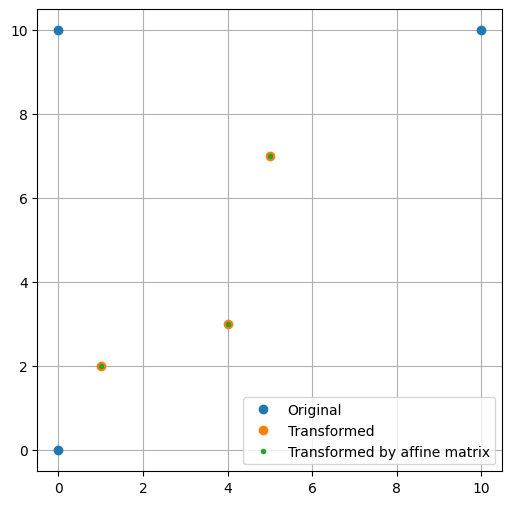

In [4]:
# 変換前と変換後をプロット
plt.figure(figsize=(6, 6))
plt.plot(matrixA[:, 0], matrixA[:, 1], 'o', label='Original')
plt.plot(matrixAdash[:, 0], matrixAdash[:, 1], 'o', label='Transformed')

# アフィン変換行列を使って変換前の点を変換
matrixA_transformed = (affine @ np.vstack((matrixA.T, np.ones(matrixA.shape[0])))).T

# 変換後の点をプロット
plt.plot(matrixA_transformed[:, 0], matrixA_transformed[:, 1], '.', label='Transformed by affine matrix')
plt.legend()
plt.grid()
plt.show()

In [5]:
# 元の3D座標
matrixA = np.array([[0, 0, 0], [10, 10, 0], [0, 10, 10]])

# 対応する変換後の3D座標
matrixAdash = np.array([[1, 2, 3], [4, 3, 7], [5, 7, 10]])

def generateAffineMatrix3D(matrix, matrix_dash) -> np.array:
    # 元の点 (matrix) と変換後の点 (matrix_dash) のサイズを確認
    assert matrix.shape[0] == 3 and matrix_dash.shape[0] == 3, "3つの点が必要です"
    
    # 元の点を拡張して 4x3 行列を作成 (x, y, z, 1)
    ones = np.ones((matrix.shape[0], 1))
    matrix_ext = np.hstack((matrix, ones))  # 3x4 の行列
    
    # 対応する変換後の点 (x', y', z', 1)
    matrix_dash_ext = np.hstack((matrix_dash, ones))  # 3x4 の行列
    
    # 最小二乗法でアフィン変換行列を計算
    affine_matrix, _, _, _ = np.linalg.lstsq(matrix_ext, matrix_dash_ext, rcond=None)
    
    # 結果を返す (4x4 のアフィン変換行列)
    return affine_matrix.T

affine = generateAffineMatrix3D(matrixA, matrixAdash)
print("3Dアフィン変換行列:")
print(affine)

3Dアフィン変換行列:
[[ 6.66666667e-02  2.33333333e-01  1.66666667e-01  1.00000000e+00]
 [-1.00000000e-01  2.00000000e-01  3.00000000e-01  2.00000000e+00]
 [ 3.33333333e-02  3.66666667e-01  3.33333333e-01  3.00000000e+00]
 [ 0.00000000e+00  1.08436148e-17  5.42180741e-18  1.00000000e+00]]


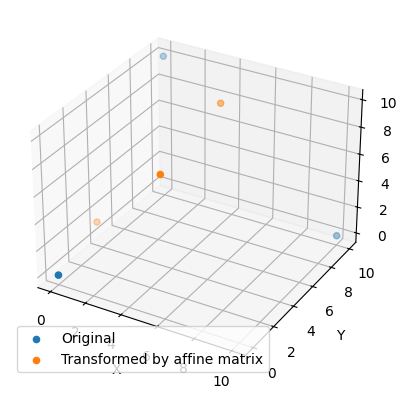

In [6]:
# 3Dプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 元の3D座標をプロット
ax.scatter(matrixA[:, 0], matrixA[:, 1], matrixA[:, 2], label='Original')

# アフィン変換行列を使って変換前の点を変換
matrixA_transformed = (affine @ np.vstack((matrixA.T, np.ones(matrixA.shape[0]))))

# 変換後の点をプロット
ax.scatter(matrixA_transformed[0], matrixA_transformed[1], matrixA_transformed[2], label='Transformed by affine matrix')

# 軸ラベル
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 凡例
ax.legend()

plt.show()

In [7]:
def generateAffineMatrix3D(matrix_affineA, matrix_affineAdash):
    # 各行列から平行移動を含む点を抽出
    points_A = np.array([mat[:3, 3] for mat in matrix_affineA])  # Aの各点 (x, y, z)
    points_Adash = np.array([mat[:3, 3] for mat in matrix_affineAdash])  # Adashの各点 (x', y', z')
    
    # アフィン変換行列を求めるための最小二乗法
    ones = np.ones((points_A.shape[0], 1))  # 点数分の1列
    P = np.hstack((points_A, ones))  # Aの点を拡張 [x, y, z, 1]
    Q = points_Adash  # Adashの点
    
    # 最小二乗法で解を求める
    affine_matrix, _, _, _ = np.linalg.lstsq(P, Q, rcond=None)
    
    # 4x4のアフィン変換行列を構築
    affine_matrix_4x4 = np.eye(4)
    affine_matrix_4x4[:3, :] = affine_matrix.T
    
    return affine_matrix_4x4

# 入力データ
matrix_affineA = np.array([
    [[1, 0, 0, 2], [0, 1, 0, 4], [0, 0, 1, 2], [0, 0, 0, 1]],
    [[1, 0, 0, 3], [0, 1, 0, 1], [0, 0, 1, 4], [0, 0, 0, 1]],
    [[1, 0, 0, 4], [0, 1, 0, 2], [0, 0, 1, 3], [0, 0, 0, 1]],
])

matrix_affineAdash = np.array([
    [[1, 0, 0, 0], [0, 1, 0, 7], [0, 0, 1, 3], [0, 0, 0, 1]],
    [[1, 0, 0, 1], [0, 1, 0, 2], [0, 0, 1, 6], [0, 0, 0, 1]],
    [[1, 0, 0, 2], [0, 1, 0, 4], [0, 0, 1, 3], [0, 0, 0, 1]],
])

# アフィン変換行列を生成
affine = generateAffineMatrix3D(matrix_affineA, matrix_affineAdash)
print("3Dアフィン変換行列:")
print(affine)

3Dアフィン変換行列:
[[ 0.91176471 -0.26470588 -0.35294118 -0.05882353]
 [ 0.21764706  1.65294118 -0.12941176  0.21176471]
 [-0.97058824  0.08823529  2.11764706  0.35294118]
 [ 0.          0.          0.          1.        ]]
